# Introduction to scikit-learn and classical machine learning for image segmentation and classification

# Let's start by installing all required libraries

In [1]:
!pip install numpy scikit_image scikit_learn matplotlib seaborn pandas tifffile -q

# Classical machine learning based segmentation

## Load the image we want to segment and display it

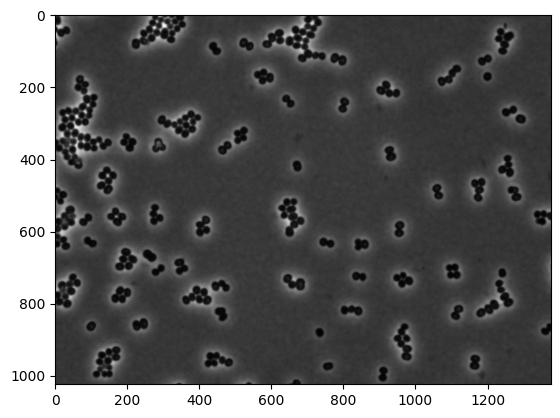

In [8]:
import numpy as np
from tifffile import imread
from matplotlib import pyplot as plt

image = imread("../data/images/sle1_phase_contrast.tif")
plt.imshow(image, cmap="gray")

## Normalize the image to values ranging from 0 to 1

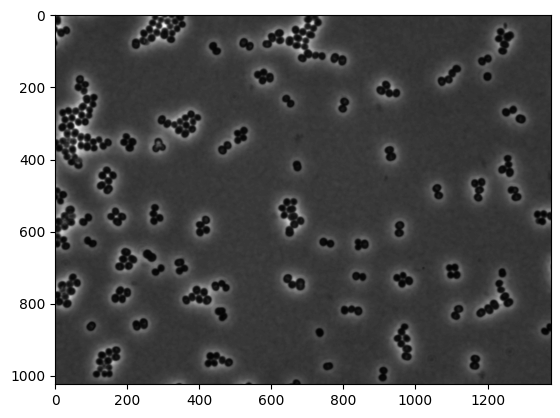

In [9]:
from skimage.exposure import rescale_intensity
image = rescale_intensity(image, out_range="float")
plt.imshow(image, cmap="gray")

## Let's start by trying to segment the image using an unsupervised approach
### k-means clustering

In [10]:
from sklearn.cluster import KMeans

flattened_image = image.reshape((-1, 1))

k = 2 # number of clusters
kmeans = KMeans(n_clusters=k, random_state=100)
kmeans.fit(flattened_image)

segmented_image = kmeans.labels_.reshape(image.shape)

## Let's display the segmented image together with the original image and ground truth mask

(np.float64(-0.5), np.float64(1375.5), np.float64(1023.5), np.float64(-0.5))

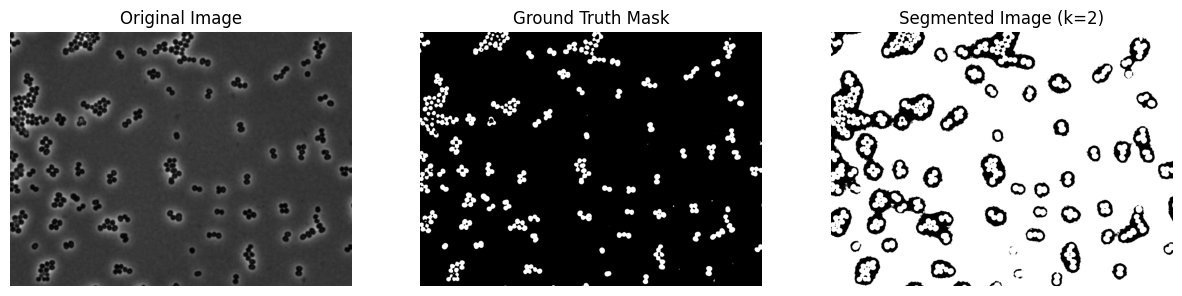

In [11]:
gt_mask = imread("../data/images/sle1_mask.tif")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f'Segmented Image (k={k})')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')

## Let's increase the number of clusters to 3

(np.float64(-0.5), np.float64(1375.5), np.float64(1023.5), np.float64(-0.5))

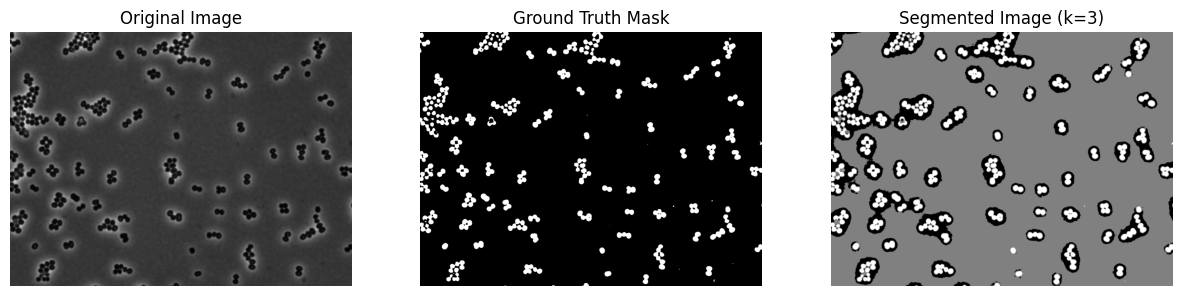

In [12]:
from sklearn.cluster import KMeans

flattened_image = image.reshape((-1, 1))

k = 3 # number of clusters
kmeans = KMeans(n_clusters=k, random_state=100)
kmeans.fit(flattened_image)

segmented_image = kmeans.labels_.reshape(image.shape)

gt_mask = imread("../data/images/sle1_mask.tif")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f'Segmented Image (k={k})')
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')

## Let's select only the highest label value of the k-means output

(np.float64(-0.5), np.float64(1375.5), np.float64(1023.5), np.float64(-0.5))

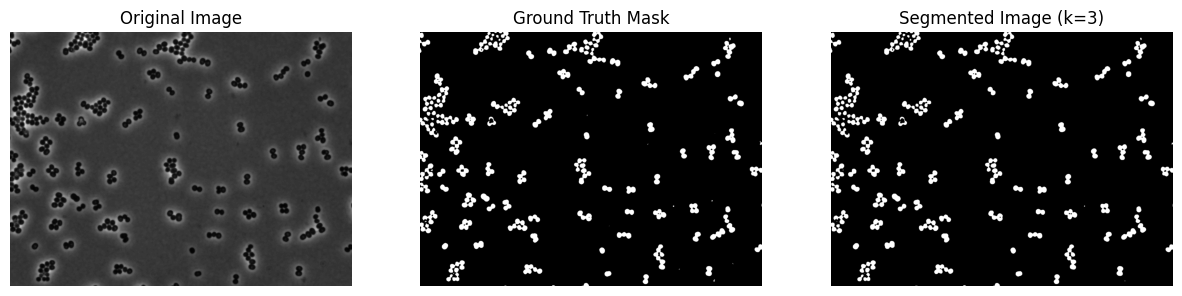

In [13]:
filtered_kmeans = segmented_image==np.max(segmented_image)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f'Segmented Image (k={k})')
plt.imshow(filtered_kmeans, cmap='gray')
plt.axis('off')

## Repeat the same task using the dna labelled images wt_dna.tif

In [ ]:
# Write your code here

### hint: you may need to adjust the number of classes and instead of selecting just one label maybe a range?

(np.float64(-0.5), np.float64(1375.5), np.float64(1023.5), np.float64(-0.5))

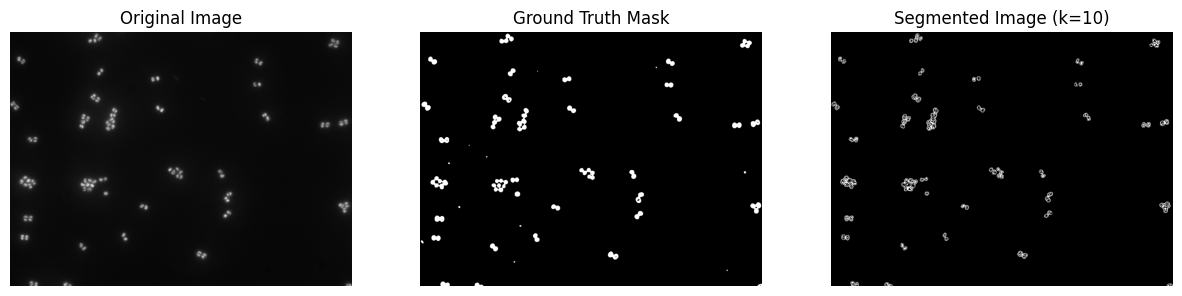

In [48]:
# solution
image = imread("../data/images/wt_dna.tif")
flattened_image = image.reshape((-1, 1))

k = 10 # number of clusters
kmeans = KMeans(n_clusters=k, random_state=100)
kmeans.fit(flattened_image)

segmented_image = kmeans.labels_.reshape(image.shape)
gt_mask = imread("../data/images/wt_mask.tif")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title(f'Segmented Image (k={k})')
plt.imshow((segmented_image<7) * (segmented_image>4), cmap='gray')
plt.axis('off')

## Let's now try a supersived machine learning approach
### Random Forest Classifier

## Let's start by manually annotating a labels image, using 1 for background and 2 for foreground

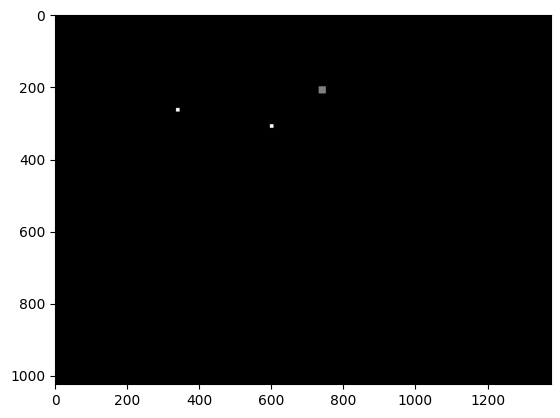

In [56]:
image = imread("../data/images/wt_dna.tif")
annotation = np.zeros_like(image)

annotation[200:220, 730:750] = 1 # background
annotation[260:270, 335:345] = 2 # cell 1
annotation[305:315, 595:605] = 2 # cell 2

plt.imshow(annotation, cmap="gray")

## Now we create a feature map for random forest classifier

(np.float64(-0.5), np.float64(1375.5), np.float64(1023.5), np.float64(-0.5))

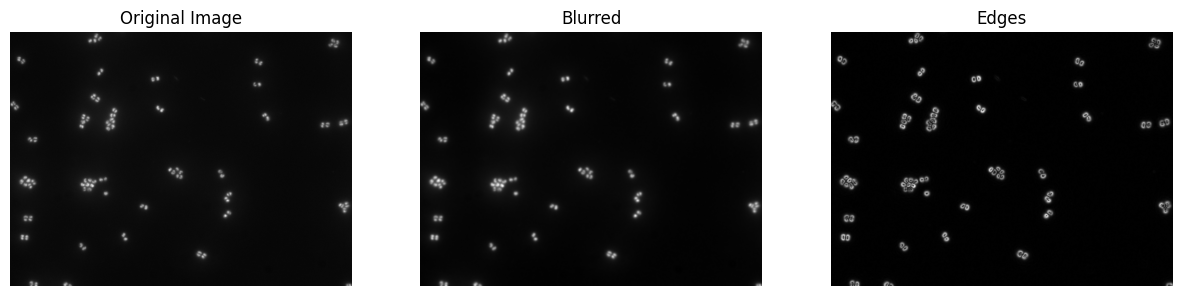

In [57]:
from skimage import filters

def generate_feature_stack(image):
    # determine features
    blurred = filters.gaussian(image, sigma=2)
    edges = filters.sobel(blurred)

    # collect features in a stack
    # The ravel() function turns a nD image into a 1-D image.
    # We need to use it because scikit-learn expects values in a 1-D format here. 
    feature_stack = [
        image.ravel(),
        blurred.ravel(),
        edges.ravel()
    ]
    
    # return stack as numpy-array
    return np.asarray(feature_stack)

feature_stack = generate_feature_stack(image)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(feature_stack[0].reshape(image.shape), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Blurred")
plt.imshow(feature_stack[1].reshape(image.shape), cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Edges")
plt.imshow(feature_stack[2].reshape(image.shape), cmap='gray')
plt.axis('off')

## Now we need to format the data to meet the scikit-learn requirements

In [58]:
def format_data(feature_stack, annotation):
    # reformat the data to match what scikit-learn expects
    # transpose the feature stack
    X = feature_stack.T
    # make the annotation 1-dimensional
    y = annotation.ravel()
    
    # remove all pixels from the feature and annotations which have not been annotated
    mask = y > 0
    X = X[mask]
    y = y[mask]

    return X, y

X, y = format_data(feature_stack, annotation)

print("input shape", X.shape)
print("annotation shape", y.shape)

input shape (600, 3)
annotation shape (600,)


## Let's train the random forest classifier

In [60]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

RandomForestClassifier(max_depth=2, random_state=0)

## Visualize how well the random forest classifier can actually segment the image

(np.float64(-0.5), np.float64(1375.5), np.float64(1023.5), np.float64(-0.5))

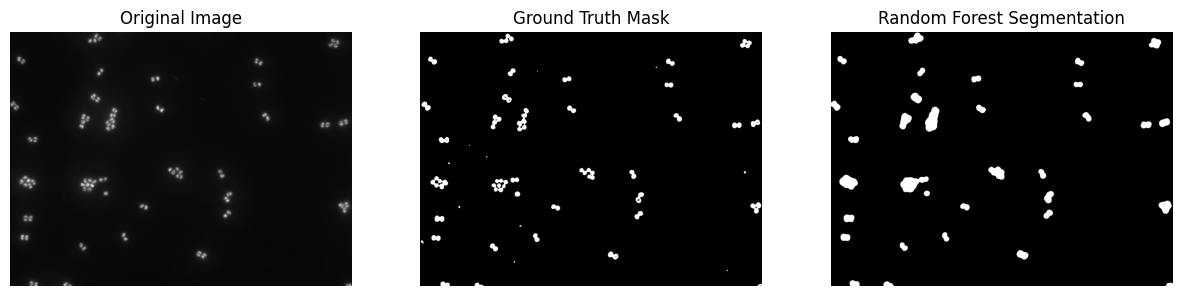

In [70]:
result = classifier.predict(feature_stack.T) - 1 # we subtract 1 to make background = 0

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Random Forest Segmentation")
plt.imshow(result.reshape(image.shape), cmap='gray')
plt.axis('off')

## Let's use napari to create a better annotation image
### make sure to save the image as .tif and inside the data/images folder with the name wt_labels.tif

(np.float64(-0.5), np.float64(1375.5), np.float64(1023.5), np.float64(-0.5))

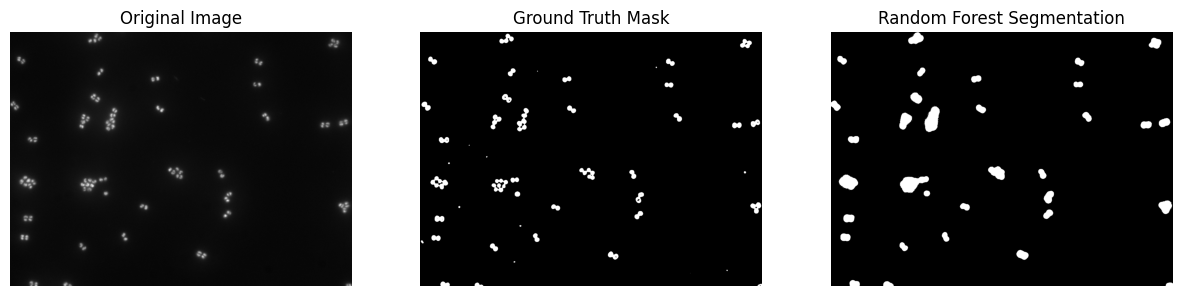

In [72]:
manual_annotations = imread("../data/images/wt_labels.tif")
feature_stack = generate_feature_stack(image)
X, y = format_data(feature_stack, manual_annotations)

# train classifier
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier.fit(X, y)

# process the whole image and show result
result = classifier.predict(feature_stack.T)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(gt_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Random Forest Segmentation")
plt.imshow(result.reshape(image.shape), cmap='gray')
plt.axis('off')